# **CS 577 S21**
---
# **Illinois Institute of Technology**
# **Department of Computer Science**
# **Project: Traffic Sign Recognition Using Deep Neural Networks**
---
# **Team Members:**
**Oleksandr Shashkov**\
**Darrel Belen**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_file = "/content/drive/Shareddrives/CS 577/data/data.zip"

Mounted at /content/drive


In [ ]:
import shutil 
import os, os.path
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image

import keras
from keras import Input
from keras import models
from keras.models import Model
from keras import layers
from keras.layers import Input, Flatten, Dense
from keras import utils
from keras import metrics
from keras import losses
from keras import optimizers
from keras import regularizers
from keras import callbacks
from keras.utils.vis_utils import plot_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16

# **Load And Prepare Data**

In [ ]:
!unzip -q -o '/content/drive/Shareddrives/CS 577/data/data.zip' -d '/content/drive/Shareddrives/CS 577/data'

In [ ]:
#cleanup maintenace
#!rm -rf '/content/drive/Shareddrives/CS 577/data/data/'

In [ ]:
train_files_count = test_files_count = valid_files_count = 0

for (root,dirs,files) in os.walk('/content/drive/Shareddrives/CS 577/data/data/train/', topdown=True):
  train_files_count += len(files)
print('Train Samples: ',train_files_count)

for (root,dirs,files) in os.walk('/content/drive/Shareddrives/CS 577/data/data/valid/', topdown=True):
  valid_files_count += len(files)
print('Validation Samples: ',valid_files_count)

for (root,dirs,files) in os.walk('/content/drive/Shareddrives/CS 577/data/data/test/', topdown=True):
  test_files_count += len(files)
print('Test Samples: ',test_files_count)

Train Samples:  593
Validation Samples:  134
Test Samples:  134


In [ ]:
# add augmentation due to limited amont of samples
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest')
#train_datagen = ImageDataGenerator(rescale=1./255)

tg_sz = 124
# no data augmentation for validation and testing
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory='/content/drive/Shareddrives/CS 577/data/data/train/',
    target_size=(tg_sz, tg_sz),
    batch_size=20,
    class_mode="sparse"
)

validation_generator = test_datagen.flow_from_directory(
    directory='/content/drive/Shareddrives/CS 577/data/data/valid/',
    target_size=(tg_sz, tg_sz),
    batch_size=20,
    class_mode="sparse"
)

test_generator = test_datagen.flow_from_directory(
    directory='/content/drive/Shareddrives/CS 577/data/data/test/',
    target_size=(tg_sz, tg_sz),
    batch_size=20,
    class_mode="sparse"
)

Found 593 images belonging to 43 classes.
Found 134 images belonging to 43 classes.
Found 134 images belonging to 43 classes.


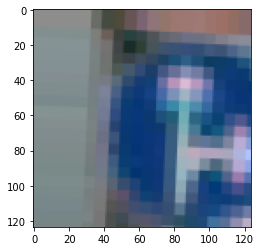

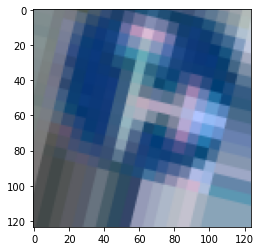

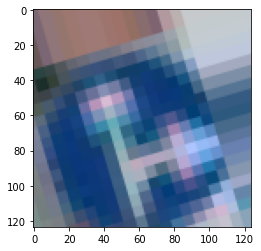

In [ ]:
# examine augmented data
fnames = [os.path.join('/content/drive/Shareddrives/CS 577/data/data/train/36',fname) for fname in os.listdir('/content/drive/Shareddrives/CS 577/data/data/train/36')]
img_path = fnames[3]
img = image.load_img(img_path, target_size=(tg_sz,tg_sz))
x = image.img_to_array(img)
x = x.reshape((1,)+x.shape)
i=0
for batch in train_datagen.flow(x,batch_size=1):
  plt.figure(i)
  implot = plt.imshow(image.array_to_img(batch[0]))
  i+=1
  if i%3==0:
    break
plt.show()

---
# **Create Models**


---
## **Construct, train and evaluate VGG16 network**
---

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 124, 124, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              18878464  
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
predictions (Dense)          (None, 43)                176171    
Total params: 50,550,635
Trainable params: 35,835,947
Non-trainable params: 14,714,688
_____________________________________

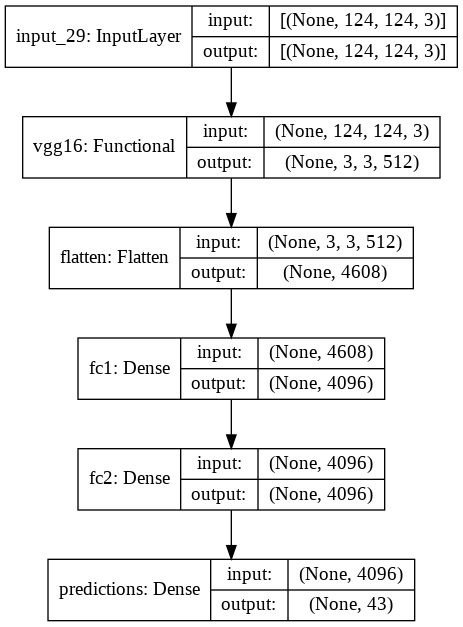

In [66]:
# VGG16
input_tensor = Input(shape=(tg_sz,tg_sz,3))

conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(tg_sz,tg_sz,3)
)
# use pre-trained VGG16 as it was not training well on our dataset
conv_base.trainable = False

output_vgg16_conv = conv_base(input_tensor)

# Customize the model adding fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
output_tensor = Dense(43, activation='softmax', name='predictions')(x)

modelvgg16 = Model(input_tensor,output_tensor)

learning_rate = 1e-3
lss = 'sparse_categorical_crossentropy'
opt = optimizers.Adam(lr=learning_rate)

modelvgg16.compile(loss=lss,
              optimizer=opt,
              metrics=['acc'])

print(modelvgg16.summary())
utils.plot_model(modelvgg16, to_file='/content/drive/Shareddrives/CS 577/model_with_vgg16.png', show_shapes=True)
display(Image(filename='/content/drive/Shareddrives/CS 577/model_with_vgg16.png'))

In [67]:
checkpoint_filepath = "/content/drive/Shareddrives/CS 577/checkpoint.h5"
checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

history = modelvgg16.fit_generator(
    train_generator,
    steps_per_epoch=30,
    epochs=100,
    callbacks=[checkpoint_callback],
    validation_data=validation_generator,
    validation_steps=7)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
30/30 [==============================] - 4s 126ms/step - loss: 5.1108 - acc: 0.1379 - val_loss: 2.8361 - val_acc: 0.2537
Epoch 2/100
30/30 [==============================] - 4s 120ms/step - loss: 2.1029 - acc: 0.3542 - val_loss: 2.4143 - val_acc: 0.2836
Epoch 3/100
30/30 [==============================] - 4s 117ms/step - loss: 1.8768 - acc: 0.4218 - val_loss: 2.2865 - val_acc: 0.3507
Epoch 4/100
30/30 [==============================] - 4s 117ms/step - loss: 1.6748 - acc: 0.4679 - val_loss: 2.1510 - val_acc: 0.3134
Epoch 5/100
30/30 [==============================] - 4s 129ms/step - loss: 1.4324 - acc: 0.5416 - val_loss: 2.1870 - val_acc: 0.3433
Epoch 6/100
30/30 [==============================] - 4s 118ms/step - loss: 1.3321 - acc: 0.5658 - val_loss: 1.9764 - val_acc: 0.4030
Epoch 7/100
30/30 [==============================] - 4s 119ms/step - loss: 1.3299 - acc: 0.5813 - val_loss: 1.9989 - val_acc: 0.4030
Epoch 8/100
30/30 [==============================] - 4s 117ms/step - 

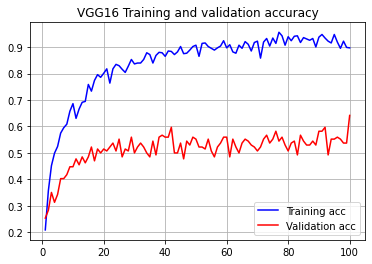

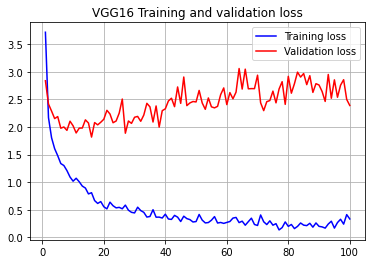

7/7 [==============================] - 0s 44ms/step - loss: 2.9357 - acc: 0.5746
Test loss:     2.94 , Test accuracy    57.46 %


In [68]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'b',label='Training acc')
plt.plot(epochs,val_acc,'r',label='Validation acc')
plt.title('VGG16 Training and validation accuracy')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs,loss,'b',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('VGG16 Training and validation loss')
plt.grid()
plt.legend()
plt.show()

modelvgg16.load_weights(checkpoint_filepath)
loss, acc = modelvgg16.evaluate(test_generator)
print('Test loss: {0:8.2f} , Test accuracy {1:8.2f} %'.format(loss,acc*100))

In [69]:
# save trained VGG16 model
path_VGG16_model = "/content/drive/Shareddrives/CS 577/model_vgg16.h5"
keras.models.save_model(modelvgg16, path_VGG16_model)

---
## **Construct, train and evaluate MobileNetV2 network**
---

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 124, 124, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_22  (None, 1280)              0         
_________________________________________________________________
predictions (Dense)          (None, 43)                55083     
Total params: 2,313,067
Trainable params: 55,083
Non-trainable params: 2,257,984
_________________________________________________________________
None


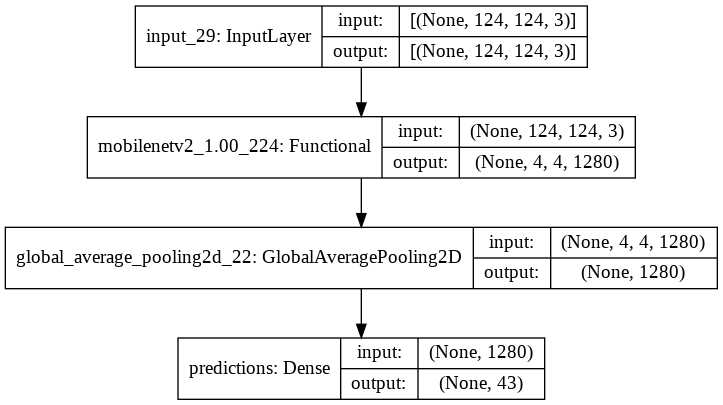

In [70]:
# MobileNetV2
conv_base2 = keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(tg_sz,tg_sz,3)
)
# Freezing weights as the netowrk did not train well for our dataset
conv_base2.trainable = False

output_MobileNetV2_conv = conv_base2(input_tensor)

# Customize the model adding fully-connected layers 
x = keras.layers.GlobalAveragePooling2D()(output_MobileNetV2_conv)
output_tensor = Dense(43, activation='softmax', name='predictions')(x)

modelMobileNetV2 = Model(input_tensor,output_tensor)

learning_rate = 1e-3
lss = 'sparse_categorical_crossentropy'
opt = optimizers.Adam(lr=learning_rate)

modelMobileNetV2.compile(loss=lss,
              optimizer=opt,
              metrics=['acc'])

print(modelMobileNetV2.summary())
utils.plot_model(modelMobileNetV2, to_file='/content/drive/Shareddrives/CS 577/model_with_modelMobileNetV2.png', show_shapes=True)
display(Image(filename='/content/drive/Shareddrives/CS 577/model_with_modelMobileNetV2.png'))

In [71]:
checkpoint_filepath = "/content/drive/Shareddrives/CS 577/checkpoint_mobilenetv2.h5"
checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

history = modelMobileNetV2.fit_generator(
    train_generator,
    steps_per_epoch=30,
    epochs=100,
    callbacks=[checkpoint_callback],
    validation_data=validation_generator,
    validation_steps=7)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
30/30 [==============================] - 6s 130ms/step - loss: 4.1946 - acc: 0.1080 - val_loss: 2.7988 - val_acc: 0.2463
Epoch 2/100
30/30 [==============================] - 3s 110ms/step - loss: 2.0776 - acc: 0.4453 - val_loss: 2.5080 - val_acc: 0.3507
Epoch 3/100
30/30 [==============================] - 3s 107ms/step - loss: 1.5585 - acc: 0.5514 - val_loss: 2.2529 - val_acc: 0.3955
Epoch 4/100
30/30 [==============================] - 3s 107ms/step - loss: 1.4307 - acc: 0.5915 - val_loss: 2.1851 - val_acc: 0.4104
Epoch 5/100
30/30 [==============================] - 3s 109ms/step - loss: 1.1112 - acc: 0.6735 - val_loss: 2.1217 - val_acc: 0.4627
Epoch 6/100
30/30 [==============================] - 3s 110ms/step - loss: 1.0113 - acc: 0.6606 - val_loss: 2.0149 - val_acc: 0.4627
Epoch 7/100
30/30 [==============================] - 3s 109ms/step - loss: 0.9241 - acc: 0.7266 - val_loss: 1.9963 - val_acc: 0.4179
Epoch 8/100
30/30 [==============================] - 3s 110ms/step - 

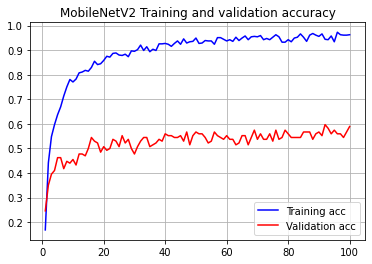

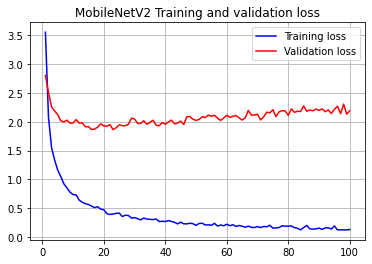

7/7 [==============================] - 0s 27ms/step - loss: 2.1233 - acc: 0.6119
Test loss:     2.12 , Test accuracy    61.19 %


In [72]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'b',label='Training acc')
plt.plot(epochs,val_acc,'r',label='Validation acc')
plt.title('MobileNetV2 Training and validation accuracy')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs,loss,'b',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('MobileNetV2 Training and validation loss')
plt.grid()
plt.legend()
plt.show()

modelMobileNetV2.load_weights(checkpoint_filepath)
loss, acc = modelMobileNetV2.evaluate(test_generator)
print('Test loss: {0:8.2f} , Test accuracy {1:8.2f} %'.format(loss,acc*100))

In [73]:
# save trained MobileNetV2 model
path_MobileNetV2_model = "/content/drive/Shareddrives/CS 577/model_MobileNetV2.h5"
keras.models.save_model(modelMobileNetV2, path_MobileNetV2_model)

In [ ]:
#modelMobileNetV2 = keras.models.load_model(path_MobileNetV2_model)
#print(modelMobileNetV2.summary())
#loss, acc = modelMobileNetV2.evaluate(test_generator)
#print('Test loss: {0:8.2f} , Test accuracy {1:8.2f} %'.format(loss,acc*100))

---
## **Construct, train and evaluate Xception network**
---

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 124, 124, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_24  (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 43)                88107     
Total params: 20,949,587
Trainable params: 20,895,059
Non-trainable params: 54,528
_________________________________________________________________
None


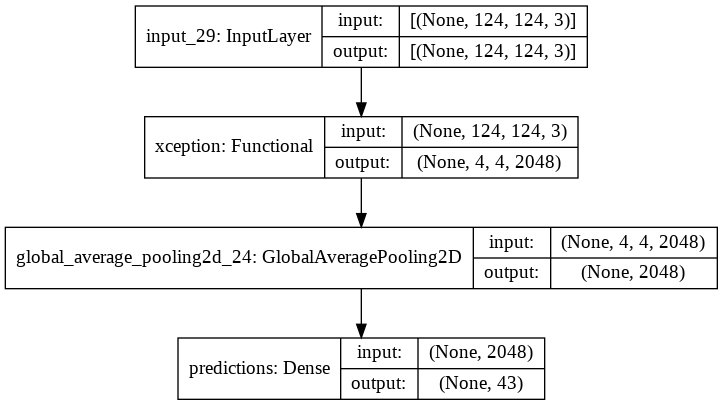

In [77]:
# Xception
conv_base3 = keras.applications.Xception(
    weights=None,
    include_top=False,
    input_shape=(tg_sz,tg_sz,3)
)
# it trains well on our data so we just go for it!
conv_base3.trainable = True

output_xception_conv = conv_base3(input_tensor)

# Customize the model adding fully-connected layers 
x = keras.layers.GlobalAveragePooling2D()(output_xception_conv)
output_tensor = Dense(43, activation='softmax', name='predictions')(x)

modelxception = Model(input_tensor,output_tensor)

learning_rate = 1e-3
lss = 'sparse_categorical_crossentropy'
opt = optimizers.Adam(lr=learning_rate)


modelxception.compile(loss=lss,
              optimizer=opt,
              metrics=['acc'])

print(modelxception.summary())
utils.plot_model(modelxception, to_file='/content/drive/Shareddrives/CS 577/model_with_modelxception.png', show_shapes=True)
display(Image(filename='/content/drive/Shareddrives/CS 577/model_with_modelxception.png'))

In [78]:
checkpoint_filepath = "/content/drive/Shareddrives/CS 577/checkpoint_modelxception.h5"
checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

history = modelxception.fit_generator(
    train_generator,
    steps_per_epoch=30,
    epochs=500,
    callbacks=[checkpoint_callback],
    validation_data=validation_generator,
    validation_steps=7)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/500
30/30 [==============================] - 9s 168ms/step - loss: 3.6144 - acc: 0.1216 - val_loss: 3.7495 - val_acc: 0.0522
Epoch 2/500
30/30 [==============================] - 5s 151ms/step - loss: 2.9745 - acc: 0.2319 - val_loss: 3.7505 - val_acc: 0.0448
Epoch 3/500
30/30 [==============================] - 4s 145ms/step - loss: 2.5673 - acc: 0.3161 - val_loss: 3.7513 - val_acc: 0.0522
Epoch 4/500
30/30 [==============================] - 5s 151ms/step - loss: 2.3883 - acc: 0.3111 - val_loss: 3.7496 - val_acc: 0.0672
Epoch 5/500
30/30 [==============================] - 4s 148ms/step - loss: 2.3098 - acc: 0.3437 - val_loss: 3.7500 - val_acc: 0.0672
Epoch 6/500
30/30 [==============================] - 4s 147ms/step - loss: 1.8842 - acc: 0.4179 - val_loss: 3.7462 - val_acc: 0.0672
Epoch 7/500
30/30 [==============================] - 5s 160ms/step - loss: 1.8305 - acc: 0.4301 - val_loss: 3.7476 - val_acc: 0.0672
Epoch 8/500
30/30 [==============================] - 4s 146ms/step - 

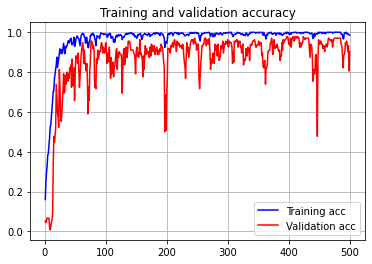

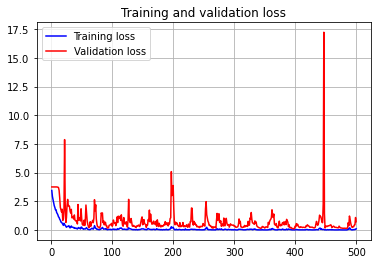

7/7 [==============================] - 0s 36ms/step - loss: 0.2043 - acc: 0.9478
Test loss:     0.20 , Test accuracy    94.78 %


In [79]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'b',label='Training acc')
plt.plot(epochs,val_acc,'r',label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs,loss,'b',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('Training and validation loss')
plt.grid()
plt.legend()
plt.show()

modelxception.load_weights(checkpoint_filepath)
loss, acc = modelxception.evaluate(test_generator)
print('Test loss: {0:8.2f} , Test accuracy {1:8.2f} %'.format(loss,acc*100))

In [80]:
# save trained Xception model
path_xception_model = "/content/drive/Shareddrives/CS 577/model_xception.h5"
keras.models.save_model(modelxception, path_xception_model)

---
## **Construct, train and evaluate InceptionResNetV2 network**
---

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 124, 124, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 2, 2, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_21  (None, 1536)              0         
_________________________________________________________________
predictions (Dense)          (None, 43)                66091     
Total params: 54,402,827
Trainable params: 54,342,283
Non-trainable params: 60,544
_________________________________________________________________
None


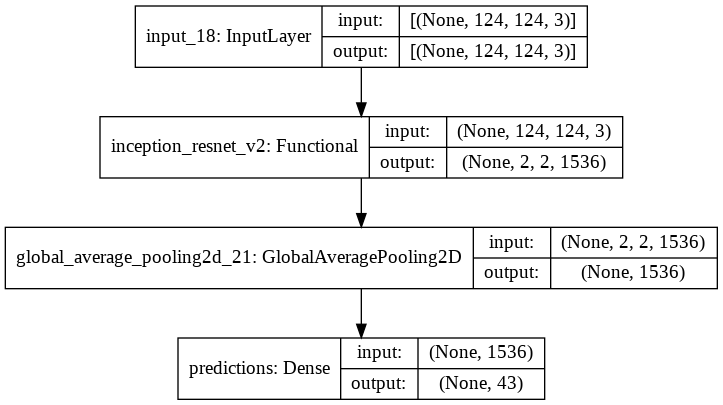

In [ ]:
conv_base4 = keras.applications.InceptionResNetV2(
    weights=None,
    include_top=False,
    input_shape=(tg_sz,tg_sz,3)
)
# It does train perfectly on our data
conv_base4.trainable = True

output_InceptionResNetV2_conv = conv_base4(input_tensor)

# Customize the model adding fully-connected layers 
x = keras.layers.GlobalAveragePooling2D()(output_InceptionResNetV2_conv)
output_tensor = Dense(43, activation='softmax', name='predictions')(x)

modelInceptionResNetV2 = Model(input_tensor,output_tensor)

learning_rate = 0.01
lss = 'sparse_categorical_crossentropy'
opt = optimizers.Adam(lr=learning_rate)

modelInceptionResNetV2.compile(loss=lss,
              optimizer=opt,
              metrics=['acc'])


print(modelInceptionResNetV2.summary())
utils.plot_model(modelInceptionResNetV2, to_file='/content/drive/Shareddrives/CS 577/model_with_modelInceptionResNetV2.png', show_shapes=True)
display(Image(filename='/content/drive/Shareddrives/CS 577/model_with_modelInceptionResNetV2.png'))

In [61]:
checkpoint_filepath = "/content/drive/Shareddrives/CS 577/checkpoint_modelInceptionResNetV2.h5"
checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

history = modelInceptionResNetV2.fit_generator(
    train_generator,
    steps_per_epoch=30,
    epochs=1000,
    callbacks=[checkpoint_callback],
    validation_data=validation_generator,
    validation_steps=7)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
30/30 [==============================] - 24s 298ms/step - loss: 6.5774 - acc: 0.0716 - val_loss: 24706873656544107429888.0000 - val_acc: 0.0597
Epoch 2/1000
30/30 [==============================] - 6s 203ms/step - loss: 4.9732 - acc: 0.0621 - val_loss: 135241637888.0000 - val_acc: 0.0597
Epoch 3/1000
30/30 [==============================] - 7s 221ms/step - loss: 4.6785 - acc: 0.0804 - val_loss: 91910600.0000 - val_acc: 0.0672
Epoch 4/1000
30/30 [==============================] - 6s 202ms/step - loss: 4.0772 - acc: 0.0903 - val_loss: 22430.1035 - val_acc: 0.0373
Epoch 5/1000
30/30 [==============================] - 7s 217ms/step - loss: 3.6305 - acc: 0.1081 - val_loss: 448.3830 - val_acc: 0.0373
Epoch 6/1000
30/30 [==============================] - 6s 201ms/step - loss: 3.7387 - acc: 0.1140 - val_loss: 23.4441 - val_acc: 0.0896
Epoch 7/1000
30/30 [==============================] - 6s 203ms/step - loss: 3.6752 - acc: 0.1175 - val_loss: 7.7450 - val_acc: 0.0597
Epoch 8/1000
3

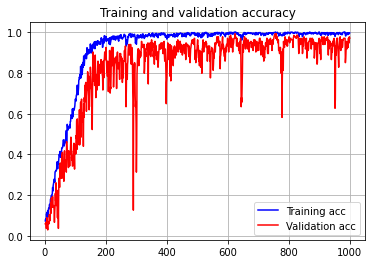

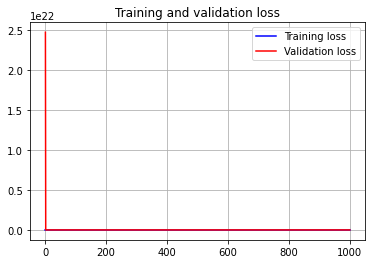

7/7 [==============================] - 1s 66ms/step - loss: 0.5335 - acc: 0.9328
Test loss:     0.53 , Test accuracy    93.28 %


In [62]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'b',label='Training acc')
plt.plot(epochs,val_acc,'r',label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs,loss,'b',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('Training and validation loss')
plt.grid()
plt.legend()
plt.show()

modelInceptionResNetV2.load_weights(checkpoint_filepath)
loss, acc = modelInceptionResNetV2.evaluate(test_generator)
print('Test loss: {0:8.2f} , Test accuracy {1:8.2f} %'.format(loss,acc*100))

In [63]:
checkpoint_filepath = "/content/drive/Shareddrives/CS 577/checkpoint_modelInceptionResNetV2.h5"
modelInceptionResNetV2.load_weights(checkpoint_filepath)
loss, acc = modelInceptionResNetV2.evaluate(test_generator)
print('Test loss: {0:8.2f} , Test accuracy {1:8.2f} %'.format(loss,acc*100))

7/7 [==============================] - 1s 70ms/step - loss: 0.5335 - acc: 0.9328
Test loss:     0.53 , Test accuracy    93.28 %


In [64]:
# save trained InceptionResNetV2 model
path_InceptionResNetV2_model = "/content/drive/Shareddrives/CS 577/model_InceptionResNetV2.h5"
keras.models.save_model(modelInceptionResNetV2, path_InceptionResNetV2_model)

---
# **Combine models into ensemble**
---

In [209]:
path_VGG16_model = "/content/drive/Shareddrives/CS 577/model_vgg16.h5"
path_MobileNetV2_model = "/content/drive/Shareddrives/CS 577/model_MobileNetV2.h5"
path_xception_model = "/content/drive/Shareddrives/CS 577/model_xception.h5"
path_InceptionResNetV2_model = "/content/drive/Shareddrives/CS 577/model_InceptionResNetV2.h5"

modelvgg16 = keras.models.load_model(path_VGG16_model)
modelvgg16._name = "VGG16"
modelMobileNetV2 = keras.models.load_model(path_MobileNetV2_model)
modelMobileNetV2._name = "MobileNetV2"
modelxception = keras.models.load_model(path_xception_model)
modelxception._name = "Xception"
modelInceptionResNetV2 = keras.models.load_model(path_InceptionResNetV2_model)
modelInceptionResNetV2._name = "InceptionResNetV2"

models = [modelvgg16, modelMobileNetV2, modelxception, modelInceptionResNetV2]
#models = [modelxception, modelInceptionResNetV2]
#models = [modelvgg16, modelMobileNetV2]

In [210]:
for mdl in models:
  loss, acc = mdl.evaluate(test_generator,verbose=0)
  print('Model: {0:20} , Test loss: {1:8.2f} , Test accuracy {2:8.2f} %'.format(mdl.name,loss,acc*100))

Model: VGG16                , Test loss:     2.94 , Test accuracy    57.46 %
Model: MobileNetV2          , Test loss:     2.12 , Test accuracy    61.19 %
Model: Xception             , Test loss:     0.20 , Test accuracy    94.78 %
Model: InceptionResNetV2    , Test loss:     0.53 , Test accuracy    93.28 %


In [211]:
def ensemble_average(models,input_tensor):
    
    outputs = [model(input_tensor) for model in models]
    y = keras.layers.Average()(outputs)
    
    model = Model(input_tensor, y, name='ensemble_average')
    
    return model

def ensemble_maximum(models,input_tensor):
    
    outputs = [model(input_tensor) for model in models]
    y = keras.layers.Maximum()(outputs)
    
    model = Model(input_tensor, y, name='ensemble_maximum')
    
    return model

In [212]:
model_ensemble_average = ensemble_average(models,input_tensor)
model_ensemble_maximum = ensemble_maximum(models,input_tensor)
model_ensemble_average.summary()
model_ensemble_maximum.summary()

Model: "ensemble_average"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 124, 124, 3) 0                                            
__________________________________________________________________________________________________
VGG16 (Functional)              (None, 43)           50550635    input_29[0][0]                   
__________________________________________________________________________________________________
MobileNetV2 (Functional)        (None, 43)           2313067     input_29[0][0]                   
__________________________________________________________________________________________________
Xception (Functional)           (None, 43)           20949587    input_29[0][0]                   
___________________________________________________________________________________

### **Evaluate performance of the ensemble**

In [213]:
print('Compiling ensembles...')
model_ensemble_average.compile(optimizer=opt,loss=lss,metrics='acc')
model_ensemble_maximum.compile(optimizer=opt,loss=lss,metrics='acc')
print('Done!')

Compiling ensembles...
Done!


In [214]:
print('Averaging Ensemble')
loss, acc = model_ensemble_average.evaluate(test_generator,verbose=0)
print('Test loss: {0:8.2f} , Test accuracy {1:8.2f} %'.format(loss,acc*100))

print('Maximizing Ensemble')
loss, acc = model_ensemble_maximum.evaluate(test_generator,verbose=0)
print('Test loss: {0:8.2f} , Test accuracy {1:8.2f} %'.format(loss,acc*100))

Averaging Ensemble
Test loss:     0.46 , Test accuracy    94.03 %
Maximizing Ensemble
Test loss:     0.64 , Test accuracy    92.54 %


Classification Report for averaging ensemble
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         9
           3       0.75      1.00      0.86         3
           4       1.00      1.00      1.00         5
           5       1.00      0.83      0.91         6
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         6
           8       1.00      0.86      0.92         7
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         9
          11       0.67      1.00      0.80         4
          12       1.00      1.00      1.00         8
          13       1.00      1.00      1.00         8
          14       0.75      1.00      0.86         3
          15       1.00      1.00      1.00         2
          16       1.00      1.00   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


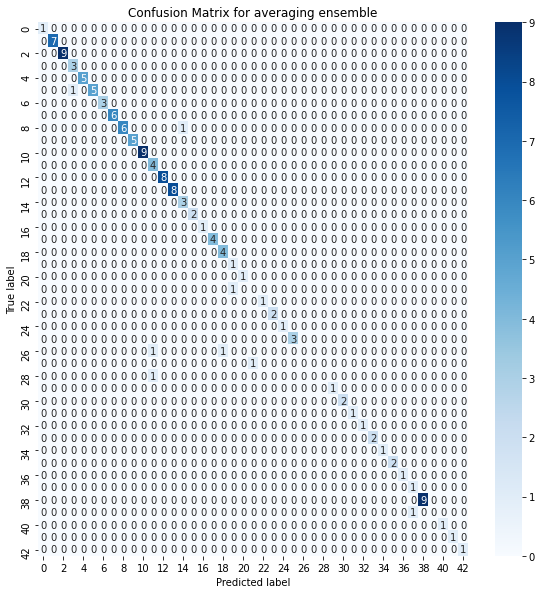

Classification Report for maximizing ensemble
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      0.86      0.92         7
           2       1.00      1.00      1.00         9
           3       0.75      1.00      0.86         3
           4       1.00      1.00      1.00         5
           5       1.00      0.67      0.80         6
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         6
           8       0.86      0.86      0.86         7
           9       1.00      1.00      1.00         5
          10       1.00      0.89      0.94         9
          11       0.67      1.00      0.80         4
          12       0.89      1.00      0.94         8
          13       1.00      1.00      1.00         8
          14       0.75      1.00      0.86         3
          15       1.00      1.00      1.00         2
          16       1.00      1.00  

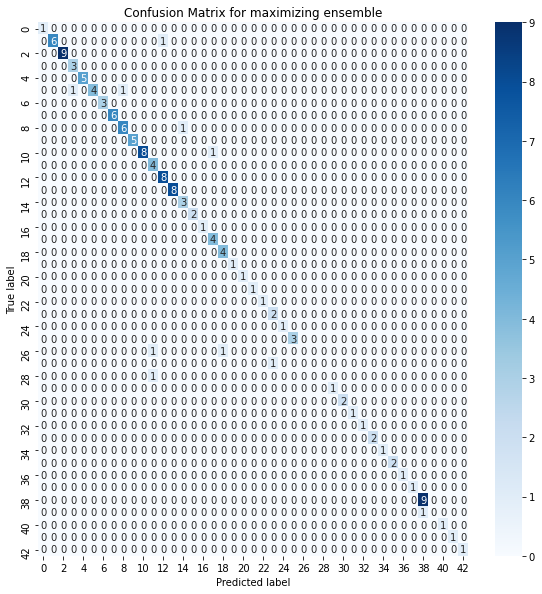

In [215]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
test_generator.shuffle = False
Y_pred = model_ensemble_average.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
con_mat = confusion_matrix(test_generator.classes, y_pred)
print('Classification Report for averaging ensemble')
print(classification_report(test_generator.classes, y_pred))

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix for averaging ensemble')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



Y_pred = model_ensemble_maximum.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

con_mat = confusion_matrix(test_generator.classes, y_pred)

print('Classification Report for maximizing ensemble')
print(classification_report(test_generator.classes, y_pred))

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix for maximizing ensemble')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()